## Objective: 

**Predicting BTCUSDT Price Trend With Deep Learinig Model**

In a series of ongoing experiments, I have been exploring the potential of machine learning in forecasting the future trend of BTC prices, with an ultimate goal to harness these predictions as indicators for a trading system. My journey began with basic models, gradually elevating to ensemble techniques, all in pursuit of accurately anticipating BTC price movements.

Initially, my strategy revolved around predicting the MACD for a 2-hour span. However, due to MACD's inherent sensitivity leading to false signals, I pivoted to using fast/slow EMAs to better discern the trend. Despite these adjustments, the predictive capability of the models remained constrained to a mere 1-2 hours into the future.

Building on these findings, this experiment aims to delve deeper. We will be integrating Deep Learning techniques, aiming to expand our forecasting horizon to 3-5 hours ahead, anticipating that such advanced models might offer us a clearer window into future BTC price movements.

**Data source**: 

- Binance
- BTCUSDT hourly prices in JSON.

**Prediction Logic**:
- **+2 (Strong Upward Trend)**: Conditions – EMA 10 > EMA 20 and exhibits an increase from its previous value.
- **+1 (Weak Upward Trend)**: Conditions – EMA 10 > EMA 20, but there's a decrease relative to its prior value.
- **-2 (Strong Downward Trend)**: Conditions – EMA 10 < EMA 20 and further decreases from its preceding value.
- **-1 (Weak Downward Trend)**: Conditions – EMA 10 < EMA 20 but shows an increase when juxtaposed with its preceding value.
- **0 (No Clear Trend)**: Conditions – differt of EMA 10 and EMA 20 between threshold values.

### Target and features

In [2]:
import numpy as np
import pandas as pd
import talib

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

    # change datetime to index
    df.set_index('datetime', inplace=True)
    
    df = remove_outlier(df)
    return df

In [3]:
def get_target_next_ema_diff(df, target_shift = 3):
    
    target_threshold = 0.2
    # oclh
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

    # diff between ema 10 and 20
    df['ema_10'] = talib.EMA(df['ohlc'], timeperiod=10)
    df['ema_20'] = talib.EMA(df['ohlc'], timeperiod=20)
    df['ema_diff'] = (df['ema_10'] - df['ema_20']) / df['ohlc'] * 100

    conditions = [
        (df['ema_diff'].isnull()),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] > df['ema_diff'].shift(1)),
        (df['ema_diff'] > target_threshold) & (df['ema_diff'] <= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] >= df['ema_diff'].shift(1)),
        (df['ema_diff'] < target_threshold * -1) & (df['ema_diff'] < df['ema_diff'].shift(1))
    ]
    values = [np.nan, 2, 1, -1, -2]
    df['target'] = np.select(conditions, values, default=0,)

    # shift target
    df['target'] = df['target'].shift(target_shift * -1)

    # drop columns
    df.drop(columns=['ohlc', 'ema_10', 'ema_20', 'ema_diff'], inplace=True)

    return df


In [6]:

def get_features_v1(df):
    df = df.copy()

    # List of periods
    periods = [3, 5, 10, 20, 25, 30, 40, 80]
    inputs = ['open', 'high', 'low', 'close', 'volume']

    # log volume
    df['volume'] = np.log(df['volume'])

    # ohlc
    df['ohlc'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
        
        
            # Generate indicators

            # % of change
            df.loc[:, f'{input}_pct_{period}'] = df[input].pct_change(periods=period)

            # EMAs
            df.loc[:, f'{input}_ema_{period}'] = talib.EMA(df[input].values, timeperiod=period)

            # RSI
            df.loc[:, f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            df.loc[:, f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            df.loc[:, f'{input}_sd_{period}'] = talib.STDDEV(df[input].values, timeperiod=period)

            # ROC
            df.loc[:, f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df.loc[:, f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)


        df = df.copy()
        
        # Multiple inputs indicators
        # ATR
        atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df.loc[:, f'price_atr_{period}'] = atr

        # Price interaction Features:
        df.loc[:, f'price_interact_{period}'] = df[f'close_pct_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df.loc[:, f'pv_interact_{period}'] = df[f'close_pct_{period}'] * df[f'volume_pct_{period}']

        # ADX
        df.loc[:, f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df.loc[:, f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df.loc[:, f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)


    df = df.copy()
    
    return df

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v1(df)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

# Count target values
print("Count", df['target'].value_counts())

print("Shape", df.shape)

df.describe()

Count target
 0.0    8794
 1.0    3703
-1.0    3701
-2.0    3264
 2.0    3212
Name: count, dtype: int64
Shape (22674, 335)


,open,high,low,close,volume,target,ohlc,open_pct_3,open_ema_3,open_rsi_3,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,...,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000,22674.000000
mean,35120.274332,35298.730460,34933.551884,35120.157750,7.956317,-0.004499,35118.178607,0.000032,35120.796354,50.139613,...,-0.000754,0.507074,0.525091,0.271077,369.695941,-1.122763,-0.000306,13.486615,50.223032,13.595222
std,13187.749013,13273.564963,13095.479428,13188.048145,0.947575,1.212040,13185.347447,0.012755,13185.569634,23.980345,...,0.029638,0.118122,11.123167,0.131429,240.669981,35.641904,0.007603,6.111916,5.729686,10.640243
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-2.000000,15690.757500,-0.113669,15715.807134,0.164893,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23357.475000,23439.215000,23267.960000,23354.960000,7.235820,-1.000000,23360.351875,-0.004726,23360.593294,31.570838,...,-0.018797,0.415272,-6.568353,0.172451,162.842582,-9.243580,-0.001891,9.130631,46.185484,5.343381
50%,31889.065000,32167.715000,31672.480000,31884.595000,7.877936,0.000000,31899.695000,0.000018,31925.792888,50.392867,...,-0.001031,0.483967,-0.102424,0.234224,315.621331,-0.103217,-0.000005,11.921275,50.033768,11.195416
75%,45447.260000,45776.905000,45150.000000,45447.270000,8.670479,1.000000,45436.619375,0.004722,45483.596568,68.738047,...,0.016359,0.586142,6.868055,0.343562,538.724486,10.468882,0.001707,16.203586,54.030463,19.275726
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,2.000000,68596.272500,0.147444,68469.229095,99.751964,...,0.124158,0.990415,330.676978,0.980922,1290.661348,227.240465,0.309765,40.244988,69.827068,74.174616


#### Test Features importance

Start from using full features set as in previous experiments, and then test features importance of target t+3

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v1(df)
df = df.dropna()

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)
y = df['target']

random_state = 55

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

model = RandomForestClassifier(random_state=random_state, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

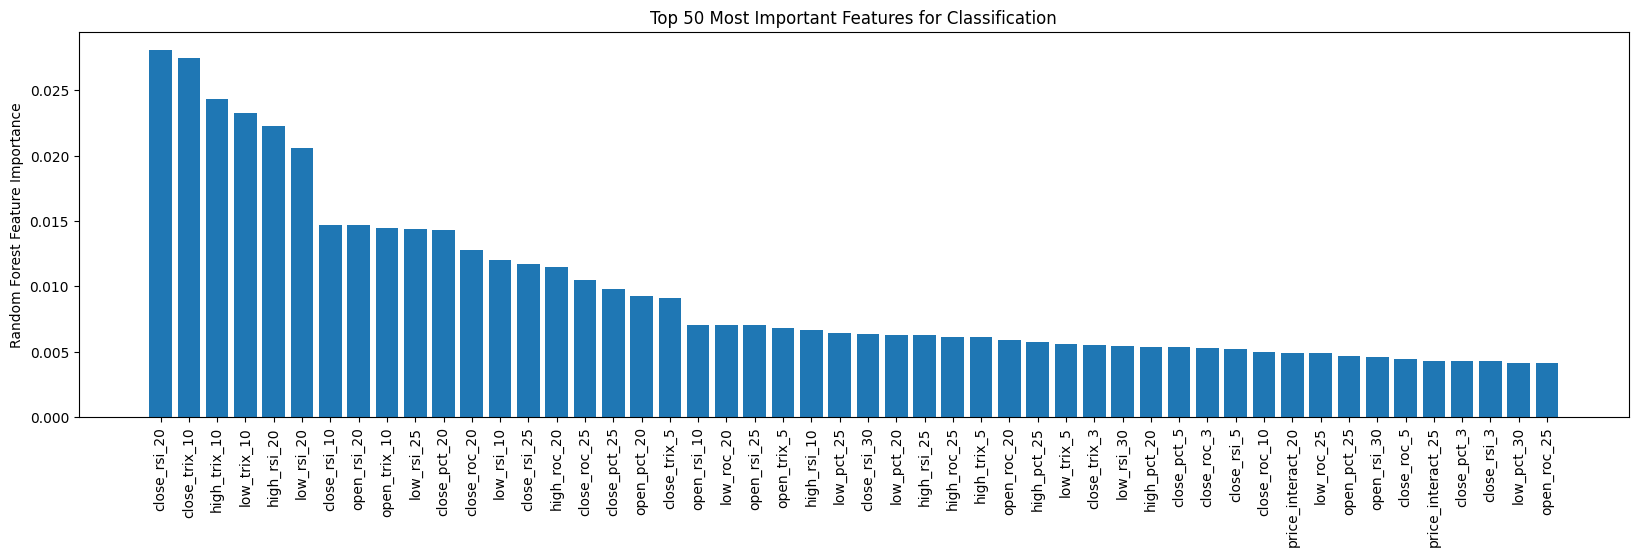

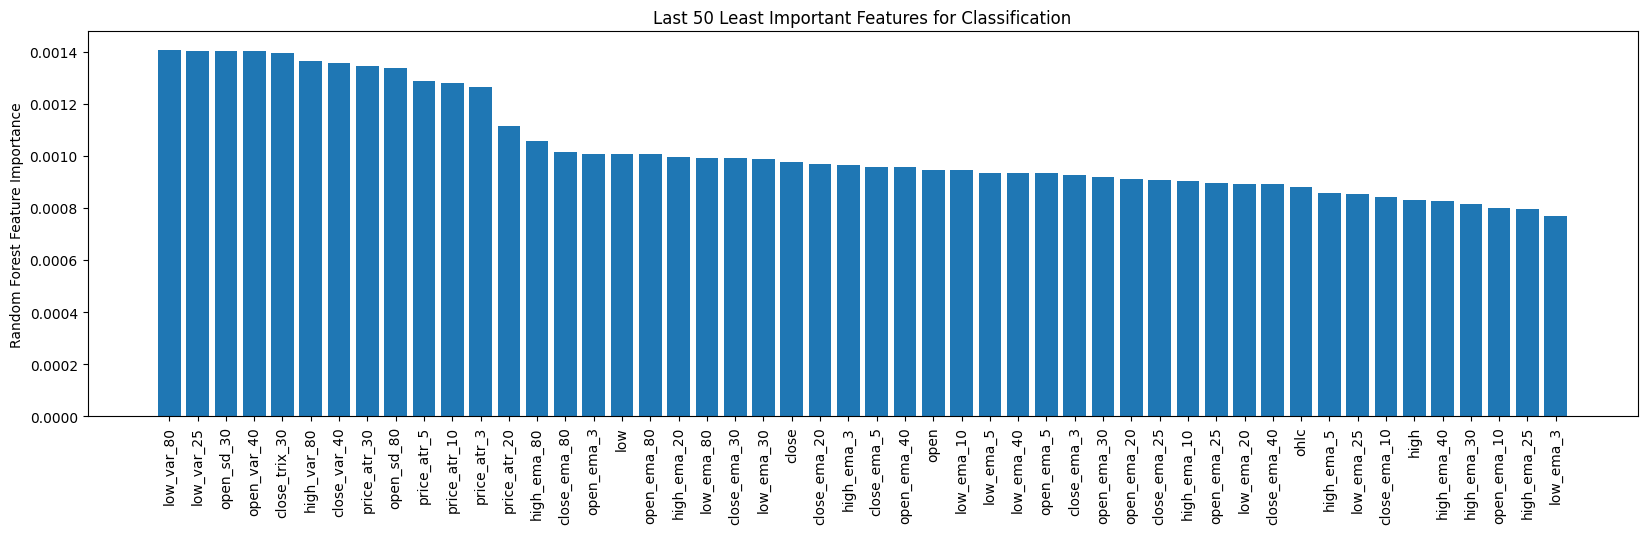

In [15]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
sorted_idx = importances.argsort()[::-1]  # Reverse the sorting order

# Get top features
top_indices = sorted_idx[:50]
top_importances = importances[top_indices]
top_features_classification = X.columns[top_indices]

plt.figure(figsize=(20, 5))
plt.bar(top_features_classification, top_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Top 50 Most Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()

# Get last 50 features
last_indices = sorted_idx[-50:]
last_importances = importances[last_indices]
last_features_classification = X.columns[last_indices]

plt.figure(figsize=(20, 5))
plt.bar(last_features_classification, last_importances)
plt.ylabel("Random Forest Feature Importance")
plt.title("Last 50 Least Important Features for Classification")
plt.xticks(rotation=90)  # Rotate feature names for clarity
plt.show()


In [ ]:
# print("top_50_features_classification =", top_features_classification)
# print("last_50_features_classification =",last_features_classification)

**Observation**:

**Top Features**:
The most significant features primarily revolve around various indicators with different periods:

1. **Relative Strength Index (RSI)**: Several periods of RSI for the close price, such as RSI 20, RSI 10, RSI 25, and RSI 30, have been highlighted as vital. RSI is a momentum oscillator that measures the speed and change of price movements.

2. **TRIX**: TRIX indicators for close, high, and low prices with periods like 10, 5, and 3 feature prominently. TRIX is a momentum oscillator that displays the percent rate of change of a triple exponentially smoothed moving average.

3. **Rate of Change (ROC)**: Various periods of ROC for close price like ROC 20 and ROC 25 are significant. ROC is a momentum oscillator that measures the percentage change between the current price and a past price.

4. **Percentage Change (PCT)**: The close price's percentage changes for periods like 20 and 25 are also key features.

5. **Other Interactions**: Features such as `price_interact_20` and `price_interact_25` hint at interactions between price and other technical indicators or periods.

**Least Important Features**:
Features that have shown to be less predictive are:

1. **Variance & Standard Deviation**: Features related to variance and standard deviation for various periods like `low_var_80`, `open_sd_30`, and `close_var_40` are among the less significant.

2. **Price Average True Range (ATR)**: Different periods of ATR like `price_atr_30` and `price_atr_5` are not highly ranked. ATR measures market volatility.

3. **Exponential Moving Averages (EMA)**: EMAs for several prices (close, open, low, high) across various periods (80, 20, 30, etc.) are also among the less significant features. EMA is a type of weighted moving average where more weight is given to the latest data.

Overall, while the most crucial features predominantly focus on momentum oscillators and their interactions across different periods, the less significant ones are spread across volatility measures, moving averages, and other indicators.

**For next steps:**

We select most importance features from top of the list to build Deep learning model
- Indicators: RSI, TRIX, ROC, PCT, price interaction
- Periods: 20, 10, 25, 5, 3


----

### Experiment 1: Test trend T+2 prediction with RNNs + LSTM

Recurrent Neural Networks (RNNs) with Long Short-Term Memory (LSTM) units are a great choice for predicting time series data due to their ability to remember long-term dependencies. Here's a brief overview of the design, layers, and dimensions:

#### Model Design:

**1. Input Layer:**
- **Dimension**: [batch_size, time_steps, number_of_features]
  - **batch_size**: The number of samples in a batch.
  - **time_steps**: The number of time periods you're using as input. For instance, if you're using the last 60 periods of data to predict the next one, your time_steps would be 60.
  - **number_of_features**: The number of features in your dataset (e.g., close price, volume, etc.).

**2. LSTM Layer(s):**
LSTM layers are the heart of the model. You can stack multiple LSTM layers to make the model more complex.

- **Units**: Number of LSTM units or cells. This is a hyperparameter to tune, but common numbers are 50, 100, or 200.
- **Return sequences**: If stacking multiple LSTM layers, set this to `True` so that the next LSTM layer receives sequences and not just the last output.
- **Dropout**: LSTMs can be prone to overfitting, so you can introduce dropout between the LSTM layers. A common dropout rate is between 0.2 to 0.5.

**3. Dense Layer(s):**
After LSTM layers, you can have one or more densely connected layers to interpret the features extracted by the LSTM layers.

- **Units**: Typically, if you're predicting the next value in a sequence, this would be 1. If you're predicting multiple future values, adjust accordingly.
- **Activation function**: `linear` for regression tasks, `sigmoid` for binary classification, and `softmax` for multi-class classification.

**4. Output Layer:**
- **Units**: If you're predicting the trend (up, down, stationary), you might have 3 units (for 3 classes) and use `softmax` activation. For regression tasks predicting the next value, you'd have 1 unit with a `linear` activation.

**Summary of Model Architecture:**
```
Input -> [LSTM -> Dropout]* -> Dense -> Output
```

*(The `[LSTM -> Dropout]*` notation means you can have multiple repeating LSTM and Dropout layers stacked on each other)*

Get V1 features from previous experiment and prediction target trend of next 2 hours

In [10]:
df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=2)
df = get_features_v1(df)
df = df.dropna()

T = 1 # number of periods to use as input features (time steps)
F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()

Count target
 0.0    8794
 1.0    3703
-1.0    3701
-2.0    3265
 2.0    3212
Name: count, dtype: int64
Data shape:  (22675, 335)
Input shape: (1, 334)


,open,high,low,close,volume,target,ohlc,open_pct_3,open_ema_3,open_rsi_3,...,volume_trix_80,volume_sd_80,volume_roc_80,volume_var_80,price_atr_80,price_interact_80,pv_interact_80,price_adx_80,mfi_80,price_dx_80
count,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,...,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000,22675.000000
mean,35119.873967,35298.328483,34933.159591,35119.758361,7.956300,-0.004587,35117.780101,0.000032,35120.395790,50.140120,...,-0.000755,0.507076,0.526308,0.271078,369.685176,-1.122711,-0.000306,13.487680,50.223016,13.595929
std,13187.596003,13273.410274,13095.323884,13187.894454,0.947557,1.212085,13185.193238,0.012755,13185.416832,23.979938,...,0.029638,0.118120,11.124430,0.131426,240.670133,35.641119,0.007603,6.113885,5.729560,10.640542
min,15648.230000,15769.990000,15476.000000,15649.520000,1.772752,-2.000000,15690.757500,-0.113669,15715.807134,0.164893,...,-0.142974,0.271230,-77.445199,0.073566,37.364503,-317.718029,-0.097869,3.709515,31.638686,0.000563
25%,23358.090000,23439.270000,23268.650000,23355.020000,7.235909,-1.000000,23360.558750,-0.004726,23360.905942,31.570849,...,-0.018797,0.415274,-6.568003,0.172453,162.822460,-9.242840,-0.001891,9.130742,46.185701,5.343601
50%,31886.190000,32163.970000,31671.810000,31883.010000,7.877897,0.000000,31896.955000,0.000018,31923.702008,50.393327,...,-0.001033,0.483973,-0.102071,0.234230,315.578927,-0.102993,-0.000005,11.921405,50.033335,11.197398
75%,45446.520000,45776.650000,45150.000000,45446.530000,8.670435,1.000000,45436.471250,0.004722,45482.877209,68.737952,...,0.016359,0.586135,6.869802,0.343554,538.694437,10.468574,0.001707,16.204552,54.030431,19.275795
max,68635.120000,69000.000000,68451.190000,68633.690000,10.265415,2.000000,68596.272500,0.147444,68469.229095,99.751964,...,0.124158,0.990415,330.676978,0.980922,1290.661348,227.240465,0.309765,40.244988,69.827068,74.174616


**Pre-processing**

We simplify input shape by using only features without time steps

input_shape = (1, feature_count)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

random_state = 55

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

# pre-processing steps
scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

# Imbalanced data
sm = SMOTE(random_state=random_state)
X_train_pre, y_train_pre = sm.fit_resample(X_train_pre, y_train)

X_train_pre = X_train_pre.reshape(-1, T, F)
X_test_pre = X_test_pre.reshape(-1, T, F)

print("X_train shape", X_train.shape)
print("X_train_pre shape", X_train_pre.shape)
print("X_test shape", X_test.shape)
print("X_test_pre shape", X_test_pre.shape)
print("==============")
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# data set = (X_train_pre, y_train_pre), (X_test_pre, y_test)

X_train shape (15872, 334)
X_train_pre shape (24685, 1, 334)
X_test shape (6803, 334)
X_test_pre shape (6803, 1, 334)
y_train shape (15872, 5)
y_test shape (6803, 5)


**Simple RNNs model**

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow_addons as tfa

input_shape = (T, F) # (time_steps, features)

# Create the LSTM model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=C, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pre, y_train_pre, epochs=50, batch_size=128, validation_data=(X_test_pre, y_test), verbose=0)

In [18]:
# plot loss and accuracy vs validation loss and accuracy
import matplotlib.pyplot as plt

def plot_rnn_training_eval(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

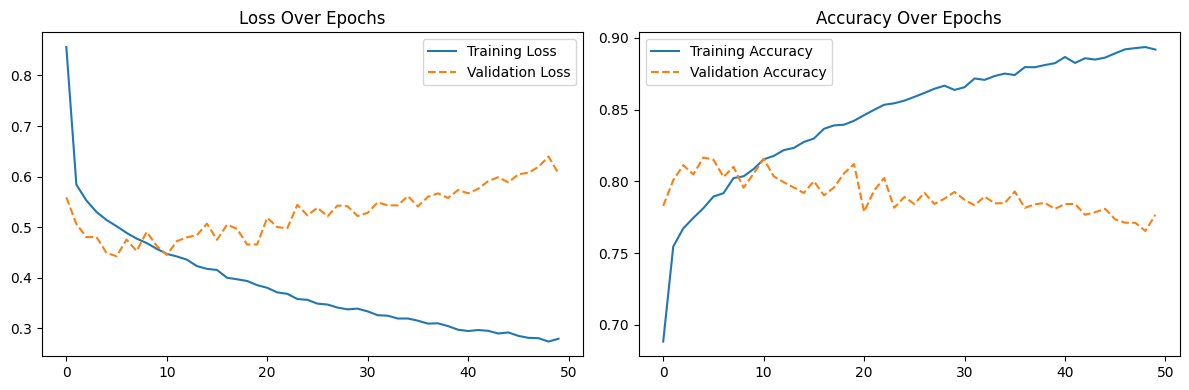

In [31]:
plot_rnn_training_eval(history)

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score


# evaluate classification model with confusion matrix
def eval_classification_model(model, X_test, y_test, one_hot_encoder=encoder):
    y_pred = model.predict(X_test, verbose=0)

    # reverse one-hot encoding
    y_test = one_hot_encoder.inverse_transform(y_test)
    y_pred = one_hot_encoder.inverse_transform(y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"Model evaluation with live data F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    return None

In [55]:
eval_classification_model(model, X_test_pre, y_test)

Confusion Matrix:
[[ 358  175  100    2    0]
 [ 240  563   38    0    0]
 [ 213   38 3381   49  176]
 [   0    0   58  560  186]
 [   0    0  105  139  422]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.44      0.56      0.50       635
        -1.0       0.73      0.67      0.70       841
         0.0       0.92      0.88      0.90      3857
         1.0       0.75      0.70      0.72       804
         2.0       0.54      0.63      0.58       666

    accuracy                           0.78      6803
   macro avg       0.67      0.69      0.68      6803
weighted avg       0.79      0.78      0.78      6803

Model evaluation with live data F1-Score: 0.7830, Accuracy: 0.7767


##### Observation:

COmparing to previous experiment, The Voting Classification model performs better in terms of precision, recall, and F1-Score compared to the Simple RNNs across most classes. The Voting Classification model also achieves a higher overall accuracy of 87.59% compared to 77.67% by the RNNs. However, the Simple `RNNs model is showing signs of overfitting`, evident from the increasing validation loss and decreasing validation accuracy over epochs.

##### Recommendations for next experiment:

Given the overfitting observed in the RNN model, the following steps might be beneficial:

1. **Regularization:** Apply dropout and potentially L1 or L2 regularization to the RNN layers.
2. **Reduce Model Complexity:** Simplify the model by reducing the number of neurons or layers.
3. **Early Stopping:** Implement early stopping during training to halt the learning process once the validation performance starts degrading.
4. **Data Augmentation:** Especially for time-series, techniques like window slicing can introduce variability in the training set.
5. **Feature Selection:** The "all features" approach in the RNN might introduce noise. Consider using only the top significant features as determined in your previous feature importance examination.

----

### Experiment 2: RNNs with LSTM simple features

**Rebuild Features with target t+2**

We will use time series data with:
- **(t) time_steps**
- **(f) features**

input shape: (time_steps, features)

##### Simple features from % change

In [113]:
import numpy as np
import pandas as pd

def get_features_v2(df, T=3):

    df = df.copy()

    # ++ Features ++
    inputs = ['open', 'high', 'low', 'close', 'volume'] 

    # log volume
    df.loc[:, 'volume'] = np.log(df['volume'])

    # range from 1 to T
    lags = [x for x in range(0, T)]

    # loop lags
    for lag in lags:
        # loop periods and inputs
        for input in inputs:
            if lag == 0:
                # % of change
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[input].pct_change(periods=1))

            else:
                # use lagged price, sort from oldest to newest
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[f'{input}_lag0'].shift(lag))

        df = df.copy()

    # drop unused columns
    drop_columns = ['open', 'high', 'low', 'close','volume']
    df.drop(columns=drop_columns, inplace=True)

    return df

In [42]:
T = 48 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=2)
df = get_features_v2(df, T=T)
df = df.dropna()

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()


Count target
 0.0    8818
 1.0    3771
-1.0    3720
-2.0    3284
 2.0    3272
Name: count, dtype: int64
Data shape:  (22865, 241)
Input shape: (48, 5)


,volume_lag47,close_lag47,low_lag47,high_lag47,open_lag47,volume_lag46,close_lag46,low_lag46,high_lag46,open_lag46,...,close_lag1,low_lag1,high_lag1,open_lag1,volume_lag0,close_lag0,low_lag0,high_lag0,open_lag0,target
count,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,...,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000,22865.000000
mean,0.001831,0.000023,0.000026,0.000018,0.000024,0.001825,0.000023,0.000025,0.000018,0.000024,...,0.000018,0.000021,0.000013,0.000020,0.001830,0.000018,0.000021,0.000014,0.000019,0.001181
std,0.062893,0.007457,0.007725,0.006787,0.007561,0.062890,0.007457,0.007725,0.006787,0.007561,...,0.007429,0.007703,0.006771,0.007534,0.062896,0.007429,0.007703,0.006771,0.007534,1.214326
min,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,...,-0.105017,-0.130847,-0.087252,-0.090518,-0.760983,-0.105017,-0.130847,-0.087252,-0.090518,-2.000000
25%,-0.035419,-0.002717,-0.002378,-0.002515,-0.002720,-0.035437,-0.002717,-0.002378,-0.002515,-0.002720,...,-0.002711,-0.002374,-0.002509,-0.002717,-0.035419,-0.002711,-0.002374,-0.002509,-0.002717,-1.000000
50%,-0.004058,0.000027,0.000289,-0.000249,0.000024,-0.004066,0.000027,0.000288,-0.000249,0.000024,...,0.000024,0.000284,-0.000253,0.000022,-0.004043,0.000024,0.000284,-0.000253,0.000022,0.000000
75%,0.032356,0.002776,0.002793,0.002256,0.002774,0.032343,0.002776,0.002793,0.002256,0.002774,...,0.002773,0.002776,0.002251,0.002770,0.032359,0.002773,0.002776,0.002251,0.002770,1.000000
max,2.849711,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,...,0.123159,0.108805,0.121771,0.142847,2.849711,0.123159,0.108805,0.121771,0.142847,2.000000


**Pre-processing**

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

random_state = 55

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

# pre-processing steps
scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

X_train_pre = X_train_pre.reshape(-1, T, F)
X_test_pre = X_test_pre.reshape(-1, T, F)

print("X_train shape", X_train.shape)
print("X_train_pre shape", X_train_pre.shape)
print("X_test shape", X_test.shape)
print("X_test_pre shape", X_test_pre.shape)
print("==============")
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# data set = (X_train_pre, y_train), (X_test_pre, y_test)

X_train shape (16005, 240)
X_train_pre shape (16005, 48, 5)
X_test shape (6860, 240)
X_test_pre shape (6860, 48, 5)
y_train shape (16005, 5)
y_test shape (6860, 5)


**Simple RNNs**

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

input_shape = (T, F) # (time_steps, features)

# Create the LSTM model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=C, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pre, y_train, epochs=50, batch_size=128, validation_data=(X_test_pre, y_test), verbose=0)

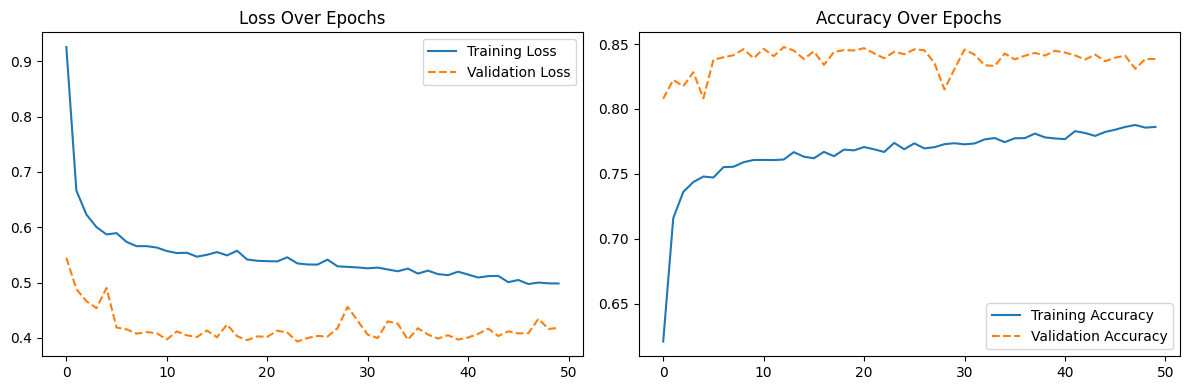

In [45]:
plot_rnn_training_eval(history)

In [46]:
eval_classification_model(model, X_test_pre, y_test)

Confusion Matrix:
[[ 349  213   72    1    0]
 [ 100  716   22    0    3]
 [  95   85 3633   34   32]
 [   0    0   84  641   98]
 [   0    0  146  123  413]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.64      0.55      0.59       635
        -1.0       0.71      0.85      0.77       841
         0.0       0.92      0.94      0.93      3879
         1.0       0.80      0.78      0.79       823
         2.0       0.76      0.61      0.67       682

    accuracy                           0.84      6860
   macro avg       0.76      0.74      0.75      6860
weighted avg       0.84      0.84      0.84      6860

Model evaluation with live data F1-Score: 0.8355, Accuracy: 0.8385


##### Observations:

Using the percentage change of features like open, high, low, close, and volume values and adding a time step of 48 hours has resulted in an overall accuracy of 84% for the RNN model. Class 0.0, which represents the neutral trend, has the highest precision and recall, indicating that the model is especially proficient at predicting this class. The model's performance for the other classes is also reasonable, but there's still room for improvement, especially for classes -2.0 and 2.0. The macro average F1-Score is 0.75, which gives a good indication of the model's balanced performance across all classes.

##### Suggestions:

The model shows no signs of overfitting after 50 epochs and the validation metrics are stable after 15 epochs, it indicates that the model has probably `converged to a local minimum` or is plateauing. Here are some steps we can take to further improve the model:

1. **Increase Model Complexity:**
   - **Deeper Network:** Add more LSTM layers to capture more complex patterns in the data.
   - **More Neurons:** Increase the number of units in the LSTM layers to allow for more complex representations.
   
3. **Learning Rate Scheduling:**
   - Gradually decrease the learning rate during training. This can help in achieving better convergence and can help the optimizer to settle in a deeper minimum.

5. **Feature Engineering:**
   - Consider creating new features or transform existing ones to help the model capture patterns better. 
   - Include `technical indicators`, if relevant and not already included, such as MACD, Bollinger Bands, etc.

6. **Sequence Length:**
   - Experiment with different time steps. Instead of 48 hours, we could try shorter or longer sequences to see if they offer better predictive power.

7. **Regularization Techniques:** 
   - Implement `L1 or L2 regularization` in the LSTM layers if overfitting starts to appear with increased model complexity.

8. **Batch Normalization:**
   - Incorporate `Batch Normalization` layers after LSTM layers to stabilize and speed up the training.

9. **Early Stopping with Model Checkpointing:**
   - Implement early stopping with model checkpointing. This will save the best model as per validation loss and stop training when the validation loss doesn't improve for a specified number of epochs.

10. **Data Augmentation for Time Series:**
   - Introduce slight variations in the training dataset by methods like jittering, slicing, or window slicing. It can make the model more robust and help generalize better.

----

### Experiment 3: RNNs with LSTM technical indicators features and regularization

**Increase model complexity with technical indicators features**

In [5]:
import numpy as np
import pandas as pd

def get_features_v3(df, T=3):

    df = df.copy()

    # ++ Features ++
    inputs = ['open', 'high', 'low', 'close', 'volume'] 
    periods = [3, 5, 10, 20, 25]

    # log volume
    df.loc[:, 'volume'] = np.log(df['volume'])

    # range from 1 to T
    lags = [x for x in range(0, T)]

    # loop lags
    for lag in lags:
        # loop periods and inputs
        for input in inputs:
            if lag == 0:
                # % of change
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[input].pct_change(periods=1))

                # Indicators by periods
                for period in periods:
                    # % of change
                    column_name = f'{input}_pct_{period}_lag{lag}'
                    df.insert(0, column_name, df[input].pct_change(periods=period))

                    # RSI
                    column_name = f'{input}_rsi_{period}_lag{lag}'
                    df.insert(0, column_name, talib.RSI(df[input].values, timeperiod=period))

                    # TRIX
                    column_name = f'{input}_trix_{period}_lag{lag}'
                    df.insert(0, column_name, talib.TRIX(df[input].values, timeperiod=period))

                    # ROC
                    column_name = f'{input}_roc_{period}_lag{lag}'
                    df.insert(0, column_name, talib.ROC(df[input].values, timeperiod=period))

            else:
                # use lagged price, sort from oldest to newest
                column_name = f'{input}_lag{lag}'
                df.insert(0, column_name, df[f'{input}_lag0'].shift(lag))

                # Indicators by periods
                for period in periods:
                    # % of change
                    column_name = f'{input}_pct_{period}_lag{lag}'
                    df.insert(0, column_name, df[f'{input}_pct_{period}_lag0'].shift(lag))
                    
                    # RSI
                    column_name = f'{input}_rsi_{period}_lag{lag}'
                    df.insert(0, column_name, df[f'{input}_rsi_{period}_lag0'].shift(lag))

                    # TRIX
                    column_name = f'{input}_trix_{period}_lag{lag}'
                    df.insert(0, column_name, df[f'{input}_trix_{period}_lag0'].shift(lag))

                    # ROC
                    column_name = f'{input}_roc_{period}_lag{lag}'
                    df.insert(0, column_name, df[f'{input}_roc_{period}_lag0'].shift(lag))

            df = df.copy()

        df = df.copy()

    # drop unused columns
    drop_columns = ['open', 'high', 'low', 'close','volume']
    df.drop(columns=drop_columns, inplace=True)

    return df

In [32]:
T = 48 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=2)
df = get_features_v3(df, T=T)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()


Count target
 0.0    8804
 1.0    3756
-1.0    3704
-2.0    3274
 2.0    3255
Name: count, dtype: int64
Data shape:  (22793, 5041)
Input shape: (48, 105)


,volume_roc_25_lag47,volume_trix_25_lag47,volume_rsi_25_lag47,volume_pct_25_lag47,volume_roc_20_lag47,volume_trix_20_lag47,volume_rsi_20_lag47,volume_pct_20_lag47,volume_roc_10_lag47,volume_trix_10_lag47,...,open_roc_5_lag0,open_trix_5_lag0,open_rsi_5_lag0,open_pct_5_lag0,open_roc_3_lag0,open_trix_3_lag0,open_rsi_3_lag0,open_pct_3_lag0,open_lag0,target
count,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,...,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000,22793.000000
mean,0.395305,-0.000690,49.935145,0.003953,0.407464,-0.000813,49.912189,0.004075,0.425261,-0.000660,...,0.007681,-0.000817,50.141038,0.000077,0.004714,-0.000747,50.170083,0.000047,0.000016,0.000614
std,9.428974,0.115019,2.934427,0.094290,9.540752,0.143324,3.603128,0.095408,9.556287,0.295794,...,1.636781,0.201085,18.947332,0.016368,1.281597,0.267707,23.981222,0.012816,0.007505,1.213733
min,-76.304045,-0.415390,27.157503,-0.763040,-76.833396,-0.572885,24.265326,-0.768334,-76.916794,-1.034757,...,-13.967500,-1.376177,1.121960,-0.139675,-11.366926,-2.289916,0.164893,-0.113669,-0.090518,-2.000000
25%,-5.394487,-0.067339,47.891488,-0.053945,-5.558253,-0.085257,47.401884,-0.055583,-5.699702,-0.196160,...,-0.603502,-0.077779,36.898398,-0.006035,-0.473833,-0.095040,31.589881,-0.004738,-0.002708,-1.000000
50%,-0.204763,0.001165,49.613534,-0.002048,-0.240628,-0.001955,49.509697,-0.002406,-0.085995,-0.014951,...,0.000948,-0.000576,50.177500,0.000009,0.002487,0.001381,50.432092,0.000025,0.000022,0.000000
75%,5.384139,0.066821,51.727988,0.053841,5.609304,0.082911,52.105700,0.056093,5.890791,0.180633,...,0.615864,0.080248,63.284978,0.006159,0.476827,0.097229,68.768603,0.004768,0.002757,1.000000
max,338.626256,0.429206,64.403163,3.386263,354.344369,0.529264,67.739443,3.543444,330.570569,1.341378,...,18.544546,1.429371,98.827914,0.185445,14.744365,2.167046,99.751964,0.147444,0.142847,2.000000


**Pre-processing**

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

random_state = 55

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

# pre-processing steps
scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

X_train_pre = X_train_pre.reshape(-1, T, F)
X_test_pre = X_test_pre.reshape(-1, T, F)

print("X_train shape", X_train.shape)
print("X_train_pre shape", X_train_pre.shape)
print("X_test shape", X_test.shape)
print("X_test_pre shape", X_test_pre.shape)
print("==============")
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# data set = (X_train_pre, y_train), (X_test_pre, y_test)

X_train shape (15955, 5040)
X_train_pre shape (15955, 48, 105)
X_test shape (6838, 5040)
X_test_pre shape (6838, 48, 105)
y_train shape (15955, 5)
y_test shape (6838, 5)


**Simple RNNs**

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

input_shape = (T, F) # (time_steps, features)

# Create the LSTM model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
model.add(Dropout(0.2))

# Second LSTM layer with dropout
model.add(LSTM(units=50))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=C, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_pre, y_train, epochs=50, batch_size=128, validation_data=(X_test_pre, y_test), verbose=0)

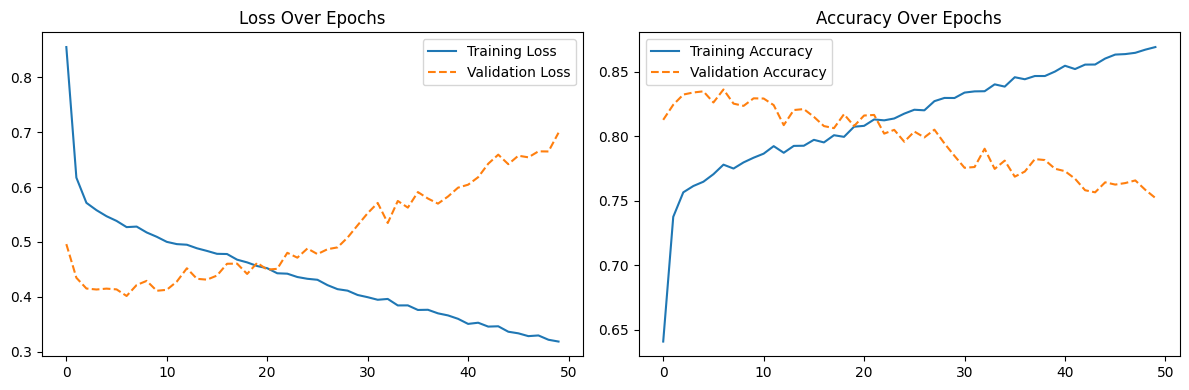

In [35]:
plot_rnn_training_eval(history)

In [36]:
eval_classification_model(model, X_test_pre, y_test)

Confusion Matrix:
[[ 276  249  108    1    1]
 [ 140  659   42    0    0]
 [ 254   58 3208   57  289]
 [   0    0   57  589  177]
 [   0    0  125  137  411]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.41      0.43      0.42       635
        -1.0       0.68      0.78      0.73       841
         0.0       0.91      0.83      0.87      3866
         1.0       0.75      0.72      0.73       823
         2.0       0.47      0.61      0.53       673

    accuracy                           0.75      6838
   macro avg       0.64      0.67      0.66      6838
weighted avg       0.77      0.75      0.76      6838

Model evaluation with live data F1-Score: 0.7592, Accuracy: 0.7521


**The model is clearly overfitted, lets apply regularization techniques.**

1. L1 or L2 Regularization
2. Batch Normalization layers after LSTM layers
3. Early stopping
4. Data Augmentation (specifically for time-series data augmentation can be challenging; a common approach is jittering.)

In [38]:
# Pre-processing 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

random_state = 55

# Pre data for classification
drop_columns = ['target']
X = df.drop(columns=drop_columns)

# One-hot encode labels
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=False)

# pre-processing steps
scaler = StandardScaler()

# Fit the scaler using the training data
X_train_pre = scaler.fit_transform(X_train)
X_test_pre = scaler.transform(X_test)

X_train_pre = X_train_pre.reshape(-1, T, F)
X_test_pre = X_test_pre.reshape(-1, T, F)

print("X_train shape", X_train.shape)
print("X_train_pre shape", X_train_pre.shape)
print("X_test shape", X_test.shape)
print("X_test_pre shape", X_test_pre.shape)
print("==============")
print("y_train shape", y_train.shape)
print("y_test shape", y_test.shape)

# data set = (X_train_pre, y_train), (X_test_pre, y_test)

X_train shape (15955, 5040)
X_train_pre shape (15955, 48, 105)
X_test shape (6838, 5040)
X_test_pre shape (6838, 48, 105)
y_train shape (15955, 5)
y_test shape (6838, 5)


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2



# Data Augmentation: Jittering
noise_factor = 0.05
X_train_pre += noise_factor * np.random.randn(*X_train_pre.shape)

input_shape = (T, F) # (time_steps, features)

# Create the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=input_shape))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 

model.add(LSTM(units=50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(BatchNormalization()) 

# Output layer
model.add(Dense(units=C, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train_pre, y_train, epochs=50, batch_size=128, validation_data=(X_test_pre, y_test), callbacks=[early_stop], verbose=0)


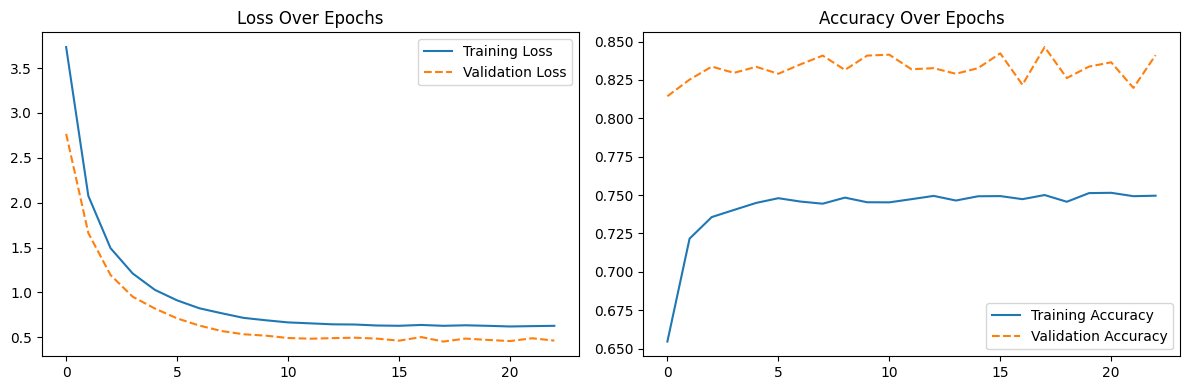

In [45]:
plot_rnn_training_eval(history)

In [46]:
eval_classification_model(model, X_test_pre, y_test)

Confusion Matrix:
[[ 368  153  113    1    0]
 [ 133  667   41    0    0]
 [  64   23 3647   60   72]
 [   0    0   40  685   98]
 [   0    0  110  142  421]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.65      0.58      0.61       635
        -1.0       0.79      0.79      0.79       841
         0.0       0.92      0.94      0.93      3866
         1.0       0.77      0.83      0.80       823
         2.0       0.71      0.63      0.67       673

    accuracy                           0.85      6838
   macro avg       0.77      0.75      0.76      6838
weighted avg       0.84      0.85      0.84      6838

Model evaluation with live data F1-Score: 0.8439, Accuracy: 0.8464


The model performs reasonably well on most classes, particularly on the class labeled "0.0", where it achieved a high precision and recall. 
- The inclusion of indicators and regularization techniques seems to have contributed `positively` to model performance, helping it achieve an overall accuracy of 84.64%.

----

### Experiment 4: Use RNNs with LSTM to predict trend in further future

**Predict trend t+3**

In [59]:
T = 24 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v3(df, T=T)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()

Count target
 0.0    8808
 1.0    3757
-1.0    3709
-2.0    3278
 2.0    3264
Name: count, dtype: int64
Data shape:  (22816, 2521)
Input shape: (24, 105)


,volume_roc_25_lag23,volume_trix_25_lag23,volume_rsi_25_lag23,volume_pct_25_lag23,volume_roc_20_lag23,volume_trix_20_lag23,volume_rsi_20_lag23,volume_pct_20_lag23,volume_roc_10_lag23,volume_trix_10_lag23,...,open_roc_5_lag0,open_trix_5_lag0,open_rsi_5_lag0,open_pct_5_lag0,open_roc_3_lag0,open_trix_3_lag0,open_rsi_3_lag0,open_pct_3_lag0,open_lag0,target
count,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,...,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000,22816.000000
mean,0.399611,-0.000703,49.935336,0.003996,0.410102,-0.000742,49.912505,0.004101,0.424399,-0.000490,...,0.009429,-0.000632,50.151989,0.000094,0.005868,-0.000451,50.184385,0.000059,0.000020,0.000877
std,9.429201,0.114989,2.934173,0.094292,9.544293,0.143300,3.602849,0.095443,9.559025,0.295957,...,1.640356,0.201325,18.948770,0.016404,1.284557,0.268249,23.984607,0.012846,0.007517,1.214168
min,-76.304045,-0.415390,27.157503,-0.763040,-76.833396,-0.572885,24.265326,-0.768334,-76.916794,-1.034757,...,-13.967500,-1.376177,1.121960,-0.139675,-11.366926,-2.289916,0.164893,-0.113669,-0.090518,-2.000000
25%,-5.391116,-0.067340,47.891636,-0.053911,-5.558568,-0.085221,47.402567,-0.055586,-5.701785,-0.196160,...,-0.603393,-0.077788,36.901734,-0.006034,-0.473488,-0.095028,31.595410,-0.004735,-0.002710,-1.000000
50%,-0.200639,0.001172,49.613823,-0.002006,-0.240433,-0.001904,49.511187,-0.002404,-0.087000,-0.014884,...,0.001392,-0.000530,50.191136,0.000014,0.003184,0.001418,50.444343,0.000032,0.000022,0.000000
75%,5.387459,0.066761,51.727392,0.053875,5.612498,0.083187,52.105047,0.056125,5.895619,0.180870,...,0.618282,0.080359,63.302707,0.006183,0.477902,0.097509,68.785415,0.004779,0.002766,1.000000
max,338.626256,0.429206,64.403163,3.386263,354.344369,0.529264,67.739443,3.543444,330.570569,1.341378,...,18.544546,1.429371,98.827914,0.185445,14.744365,2.167046,99.751964,0.147444,0.142847,2.000000


In [174]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2

import matplotlib.pyplot as plt
import time
import joblib

def plot_rnn_training_eval(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.legend()
    plt.title('Loss Over Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linestyle='--')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

    return None

def eval_classification_model(model, X_test, y_test, one_hot_encoder=encoder):
    y_pred = model.predict(X_test, verbose=0)

    # reverse one-hot encoding
    y_test = one_hot_encoder.inverse_transform(y_test)
    y_pred = one_hot_encoder.inverse_transform(y_pred)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"Model evaluation with live data F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    return None

def train_dl_trend_prediction_model(df, T, model_name = 'tmp_model', model_path = './models/', test_size=0.1, random_state = 55, epochs=50, show_eval=True):
    time_start = time.time()

    # Pre-processing 
    drop_columns = ['target']
    X = df.drop(columns=drop_columns)

    # One-hot encode labels
    encoder = OneHotEncoder(sparse_output=False)
    y = encoder.fit_transform(df['target'].values.reshape(-1, 1))

    # save encoder
    encoder_filepath = model_path + model_name + '_encoder.joblib'
    joblib.dump(encoder, encoder_filepath)

    # Dimension parameters
    F = int((df.shape[1] -1) / T) # number of input features 
    C = y.shape[1] # number of classes
    # print(f"Input shape: ({T}, {F})")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=False)

    # Fit the scaler using the training data
    scaler = StandardScaler()
    
    X_train_pre = scaler.fit_transform(X_train)
    X_test_pre = scaler.transform(X_test)

    # save scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    joblib.dump(scaler, scaler_filepath)

    X_train_pre = X_train_pre.reshape(-1, T, F)
    X_test_pre = X_test_pre.reshape(-1, T, F)

    # Data Augmentation: Jittering
    noise_factor = 0.01
    X_train_pre += noise_factor * np.random.randn(*X_train_pre.shape)

    # data set = (X_train_pre, y_train), (X_test_pre, y_test)

    # Deep learning model
    input_shape = (T, F) # (time_steps, features)

    # Create the LSTM model
    model = Sequential()

    model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(BatchNormalization()) 

    model.add(LSTM(units=50, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization()) 

    # Output layer
    model.add(Dense(units=C, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(X_train_pre, y_train, epochs=epochs, batch_size=128, validation_data=(X_test_pre, y_test), callbacks=[early_stop], verbose=0)

    # save deep learning model
    model_filepath = model_path + model_name + '_model.keras'
    model.save(model_filepath)

    if show_eval:
        plot_rnn_training_eval(history)
        eval_classification_model(model, X_test_pre, y_test, one_hot_encoder=encoder)

    return model

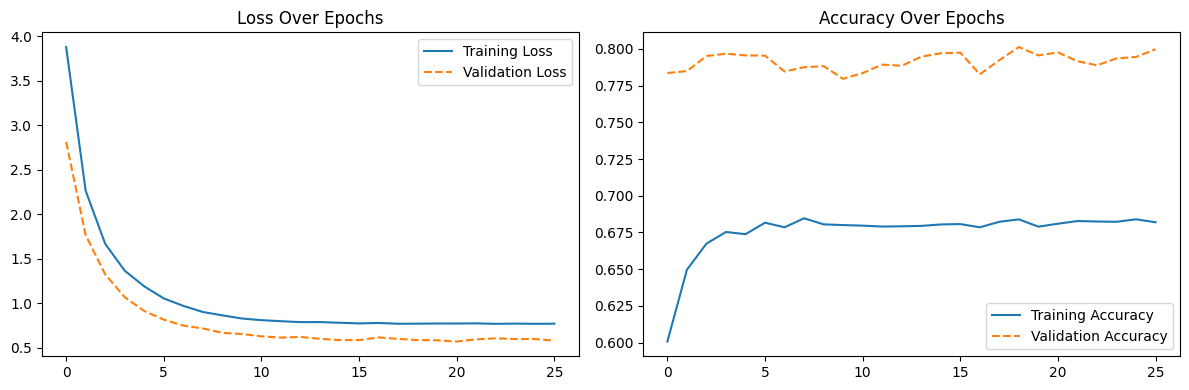

Confusion Matrix:
[[ 244  200  189    2    0]
 [  96  674   71    0    0]
 [  82   50 3561   87   86]
 [   0    0   39  685   99]
 [   1    0  180  203  296]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.58      0.38      0.46       635
        -1.0       0.73      0.80      0.76       841
         0.0       0.88      0.92      0.90      3866
         1.0       0.70      0.83      0.76       823
         2.0       0.62      0.44      0.51       680

    accuracy                           0.80      6845
   macro avg       0.70      0.67      0.68      6845
weighted avg       0.79      0.80      0.79      6845

Model evaluation with live data F1-Score: 0.7876, Accuracy: 0.7977


In [61]:
train_dl_trend_prediction_model(df, T, model_name = 'dl_btc_ema_3hr_trend',test_size=0.3, epochs=50)

**Predict trend t+4**

In [175]:
T = 24 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=4)
df = get_features_v3(df, T=T)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
# df.describe()

Count target
 0.0    8807
 1.0    3757
-1.0    3709
-2.0    3278
 2.0    3264
Name: count, dtype: int64
Data shape:  (22815, 2521)
Input shape: (24, 105)


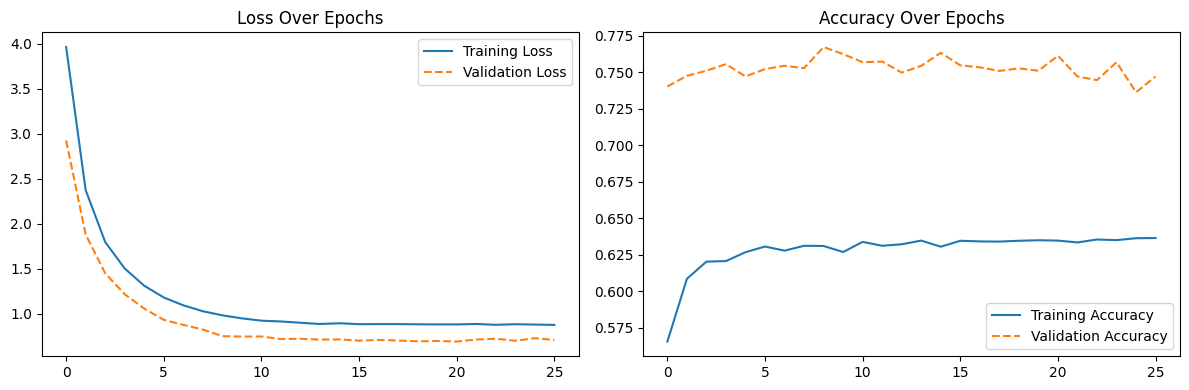

Confusion Matrix:
[[ 190  190  249    4    2]
 [ 133  633   75    0    0]
 [ 101   62 3528   85   90]
 [   0    0   92  659   72]
 [   2    0  261  216  201]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.45      0.30      0.36       635
        -1.0       0.72      0.75      0.73       841
         0.0       0.84      0.91      0.87      3866
         1.0       0.68      0.80      0.74       823
         2.0       0.55      0.30      0.38       680

    accuracy                           0.76      6845
   macro avg       0.65      0.61      0.62      6845
weighted avg       0.74      0.76      0.74      6845

Model evaluation with live data F1-Score: 0.7440, Accuracy: 0.7613


In [176]:
model = train_dl_trend_prediction_model(df, T, model_name = 'dl_btc_ema_4hr_trend',test_size=0.3, epochs=50)

**Predict trend t+5**

In [64]:
T = 24 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=5)
df = get_features_v3(df, T=T)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
df.describe()

Count target
 0.0    8807
 1.0    3757
-1.0    3709
-2.0    3277
 2.0    3264
Name: count, dtype: int64
Data shape:  (22814, 2521)
Input shape: (24, 105)


,volume_roc_25_lag23,volume_trix_25_lag23,volume_rsi_25_lag23,volume_pct_25_lag23,volume_roc_20_lag23,volume_trix_20_lag23,volume_rsi_20_lag23,volume_pct_20_lag23,volume_roc_10_lag23,volume_trix_10_lag23,...,open_roc_5_lag0,open_trix_5_lag0,open_rsi_5_lag0,open_pct_5_lag0,open_roc_3_lag0,open_trix_3_lag0,open_rsi_3_lag0,open_pct_3_lag0,open_lag0,target
count,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,...,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000,22814.000000
mean,0.400131,-0.000703,49.935502,0.004001,0.411253,-0.000741,49.912700,0.004113,0.425166,-0.000449,...,0.009397,-0.000637,50.151237,0.000094,0.005874,-0.000458,50.183563,0.000059,0.000020,0.000964
std,9.429304,0.114994,2.934246,0.094293,9.543739,0.143306,3.602944,0.095437,9.559082,0.295939,...,1.640420,0.201333,18.949409,0.016404,1.284613,0.268260,23.985403,0.012846,0.007517,1.214149
min,-76.304045,-0.415390,27.157503,-0.763040,-76.833396,-0.572885,24.265326,-0.768334,-76.916794,-1.034757,...,-13.967500,-1.376177,1.121960,-0.139675,-11.366926,-2.289916,0.164893,-0.113669,-0.090518,-2.000000
25%,-5.390419,-0.067343,47.891818,-0.053904,-5.557033,-0.085221,47.402968,-0.055570,-5.700527,-0.196124,...,-0.603413,-0.077805,36.901318,-0.006034,-0.473646,-0.095036,31.595167,-0.004736,-0.002710,-1.000000
50%,-0.200639,0.001172,49.614256,-0.002006,-0.239926,-0.001904,49.512425,-0.002399,-0.085508,-0.014878,...,0.001392,-0.000536,50.187717,0.000014,0.003229,0.001407,50.442923,0.000032,0.000022,0.000000
75%,5.387770,0.066764,51.727789,0.053878,5.614224,0.083206,52.105482,0.056142,5.896022,0.180876,...,0.618254,0.080361,63.303624,0.006183,0.477940,0.097511,68.785428,0.004779,0.002766,1.000000
max,338.626256,0.429206,64.403163,3.386263,354.344369,0.529264,67.739443,3.543444,330.570569,1.341378,...,18.544546,1.429371,98.827914,0.185445,14.744365,2.167046,99.751964,0.147444,0.142847,2.000000


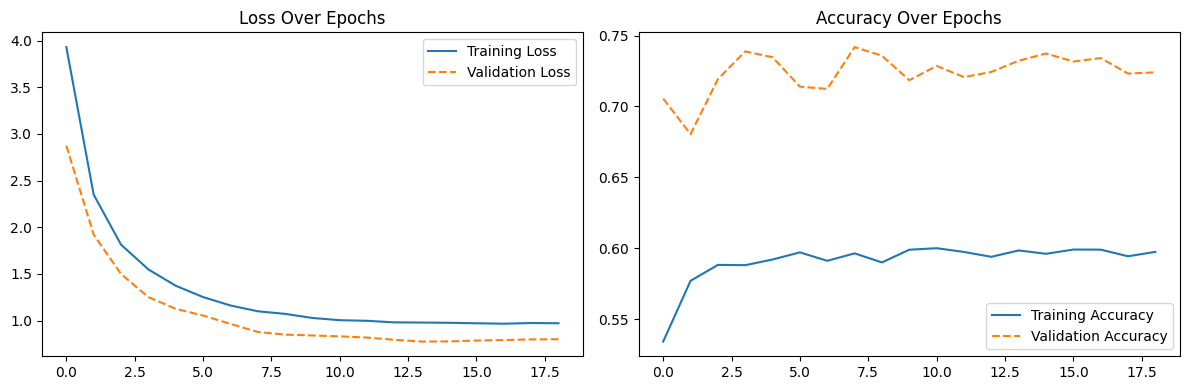

Confusion Matrix:
[[  92  233  302    6    2]
 [  66  696   79    0    0]
 [  81  128 3463  104   90]
 [   0    0  106  606  111]
 [   0    5  352  168  155]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.38      0.14      0.21       635
        -1.0       0.66      0.83      0.73       841
         0.0       0.80      0.90      0.85      3866
         1.0       0.69      0.74      0.71       823
         2.0       0.43      0.23      0.30       680

    accuracy                           0.73      6845
   macro avg       0.59      0.57      0.56      6845
weighted avg       0.70      0.73      0.70      6845

Model evaluation with live data F1-Score: 0.7034, Accuracy: 0.7322


In [66]:
model = train_dl_trend_prediction_model(df, T, model_name = 'dl_btc_ema_5hr_trend',test_size=0.3, epochs=50)

##### Observation:
  
- The model seems to be particularly proficient at predicting the "0.0" class across all time horizons, indicating it might be most comfortable predicting a neutral trend.
- As the forecasting horizon extends (from 3 hours to 5 hours), the model's performance appears to `decline`. This can be expected as predicting farther into the future is generally more challenging due to the `increased uncertainty`.
- The consistently lower performance in the "-2.0" and "2.0" classes might suggest that the model struggles with more extreme trends or less frequent events.

To potentially enhance the performance for extended forecasting periods and the extreme classes, further feature engineering, different model architectures, or incorporation of more data might be beneficial.

----

### Experiment 5: Test RNNs + LSTM model with Live data

**Training set t+3**

In [177]:
T = 24 # number of periods to use as input features (time steps)

df = read_hist_data()
df = get_target_next_ema_diff(df, target_shift=3)
df = get_features_v3(df, T=T)
df = df.dropna()

# print(df.head(5))
# print(df.tail(5))

F = int((df.shape[1] -1) / T) # number of input features 
C = 5 # number of classes

# Count target values
print("Count", df['target'].value_counts())

print("Data shape: ", df.shape ) 
print(f"Input shape: ({T}, {F})")
# df.describe()

Count target
 0.0    8808
 1.0    3757
-1.0    3709
-2.0    3278
 2.0    3264
Name: count, dtype: int64
Data shape:  (22816, 2521)
Input shape: (24, 105)


**Fetch BTCUSDT-1h data 1,000 rows from binance API**

In [194]:
import requests
import pandas as pd
import json
import datetime

def format_live_binance_data(df):

    # use only completed hour
    df = df[df['close_time'] <= datetime.datetime.now(datetime.timezone.utc).strftime("%Y-%m-%d %H:%M:%S")] 

    df_live = pd.DataFrame()
    df_live['datetime'] = df['open_time']
    df_live['open'] = df['open']
    df_live['high'] = df['high']
    df_live['low'] = df['low']
    df_live['close'] = df['close']
    df_live['volume'] = df['volume']
    
    return df_live

def fetch_live_binance_data(name = 'BTC', timeframe = '1h', limit = 1000):
    url = f"https://api.binance.com/api/v3/klines?symbol={name}USDT&interval={timeframe}&limit={limit}"
    response = requests.get(url)
    df = pd.DataFrame(json.loads(response.text))
    df.columns = ['open_time',
                'open', 'high', 'low', 'close', 'volume',
                'close_time', 'quote_asset_volume', 'number_of_trades',
                'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    
    df = df.astype(float)
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

    df = format_live_binance_data(df)

    # set datetime as index
    df = df.set_index('datetime')

    # data shape
    print(f"Data shape: {df.shape}")

    return df

df_live = fetch_live_binance_data()

print(df_live.head(5))
print(df_live.tail(5))

Data shape: (999, 5)
                         open      high       low     close      volume
datetime                                                               
2023-08-22 11:00:00  26047.48  26066.00  26027.22  26049.64   788.43624
2023-08-22 12:00:00  26049.63  26100.23  26044.94  26044.94   758.08081
2023-08-22 13:00:00  26044.94  26059.00  25969.31  25998.93  1443.50715
2023-08-22 14:00:00  25998.94  26059.00  25945.66  25994.21  1507.16702
2023-08-22 15:00:00  25994.20  26025.00  25914.03  25936.61  1374.78354
                         open      high       low     close      volume
datetime                                                               
2023-10-02 21:00:00  27843.68  27873.40  27281.44  27472.22  3838.33841
2023-10-02 22:00:00  27472.23  27558.46  27351.00  27554.56  2133.91788
2023-10-02 23:00:00  27554.55  27618.48  27472.48  27494.51  1690.95348
2023-10-03 00:00:00  27494.51  27572.00  27401.00  27430.00  2642.16570
2023-10-03 01:00:00  27430.00  27564.60  27

**Remove training data in live data**

In [195]:
# earliest date time in live data
earliest_datetime = df_live.index.min()
print(f"Remove traning data after {earliest_datetime}")

# Remove training data in df after 2023-08-10 17:00:00
df_train = df[df.index < earliest_datetime]

print(f"Original training data shape: {df.shape}")
print(f"Unseen training data shape: {df_train.shape}")

Remove traning data after 2023-08-22 11:00:00
Original training data shape: (22816, 2521)
Unseen training data shape: (22797, 2521)


**Train model with unseen data**

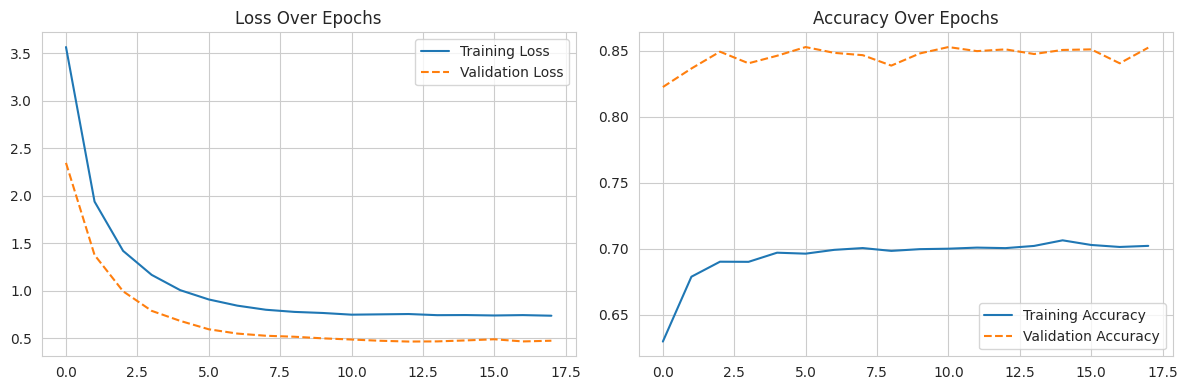

Confusion Matrix:
[[  56   61   47    0    0]
 [  14  197    8    0    0]
 [  10   22 1479   13   17]
 [   0    0   29  154   20]
 [   0    0   54   45   54]]

Classification Report:
              precision    recall  f1-score   support

        -2.0       0.70      0.34      0.46       164
        -1.0       0.70      0.90      0.79       219
         0.0       0.91      0.96      0.94      1541
         1.0       0.73      0.76      0.74       203
         2.0       0.59      0.35      0.44       153

    accuracy                           0.85      2280
   macro avg       0.73      0.66      0.67      2280
weighted avg       0.84      0.85      0.84      2280

Model evaluation with live data F1-Score: 0.8377, Accuracy: 0.8509


In [196]:
model = train_dl_trend_prediction_model(df_train, T=T, model_name = 'dl_btc_ema_3hr_trend_unseen',test_size=0.1, epochs=50)

**Predict and evaluate trend for live data**

In [197]:
def predict_live_data(df_live, T, model_name = 'tmp_model', model_path = './models/', feature_function='get_features_v3'):
    # Get features
    X_live = df_live.copy()
    X_live = globals()[feature_function](X_live, T=T)
    X_live.dropna(inplace=True)

    # Dimension parameters
    F = int((X_live.shape[1]) / T) # number of input features 
    # print(f"Input shape: ({T}, {F})")

    # load scaler
    scaler_filepath = model_path + model_name + '_scaler.joblib'
    scaler = joblib.load(scaler_filepath)
    X_live_pre = scaler.transform(X_live)

    X_live_pre = X_live_pre.reshape(-1, T, F)

    # load deep learning model
    model_filepath = model_path + model_name + '_model.keras'
    model = tf.keras.models.load_model(model_filepath)

    # predict
    y_pred = model.predict(X_live_pre, verbose=0)

    # load encoder
    encoder_filepath = model_path + model_name + '_encoder.joblib'
    encoder = joblib.load(encoder_filepath)

    # reverse one-hot encoding
    y_pred = encoder.inverse_transform(y_pred)
    y_pred = y_pred.flatten()

    # insert missing prediction with nan
    len_diff = len(df_live) - len(y_pred)
    y_pred = np.insert(y_pred, 0,  [np.nan] * len_diff, axis=0)

    return y_pred

# y_live_pred = predict_live_data(df_live, T, model_name = 'dl_btc_ema_3hr_trend_unseen')

In [198]:
def evaluate_live_data(df_live, T, model_name = 'tmp_model', model_path = './models/', target_shift=3):
    # Get prediction result
    y_live_pred = predict_live_data(df_live, T, model_name = model_name, model_path = model_path)

    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # Get target
    pred_result = get_target_next_ema_diff(pred_result, target_shift=target_shift)
    pred_result.dropna(inplace=True)

    y_test = pred_result['target']
    y_pred = pred_result['prediction']
    
    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print("Confusion Matrix")
    print(confusion_matrix(y_test, y_pred))

    print("Classification Report")
    print(classification_report(y_test, y_pred))

    print(f"Model evaluation with live data F1-Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    return pred_result

pred_result = evaluate_live_data(df_live, T, model_name = 'dl_btc_ema_3hr_trend_unseen', target_shift=3)

Confusion Matrix
[[ 13  15  12   0   0]
 [  3  50   2   0   0]
 [  1   5 628   9   3]
 [  0   0  11  66  10]
 [  0   0  26  15  31]]
Classification Report
              precision    recall  f1-score   support

        -2.0       0.76      0.33      0.46        40
        -1.0       0.71      0.91      0.80        55
         0.0       0.92      0.97      0.95       646
         1.0       0.73      0.76      0.75        87
         2.0       0.70      0.43      0.53        72

    accuracy                           0.88       900
   macro avg       0.77      0.68      0.70       900
weighted avg       0.87      0.88      0.86       900

Model evaluation with live data F1-Score: 0.8644, Accuracy: 0.8756


**Predict and plot with live data**

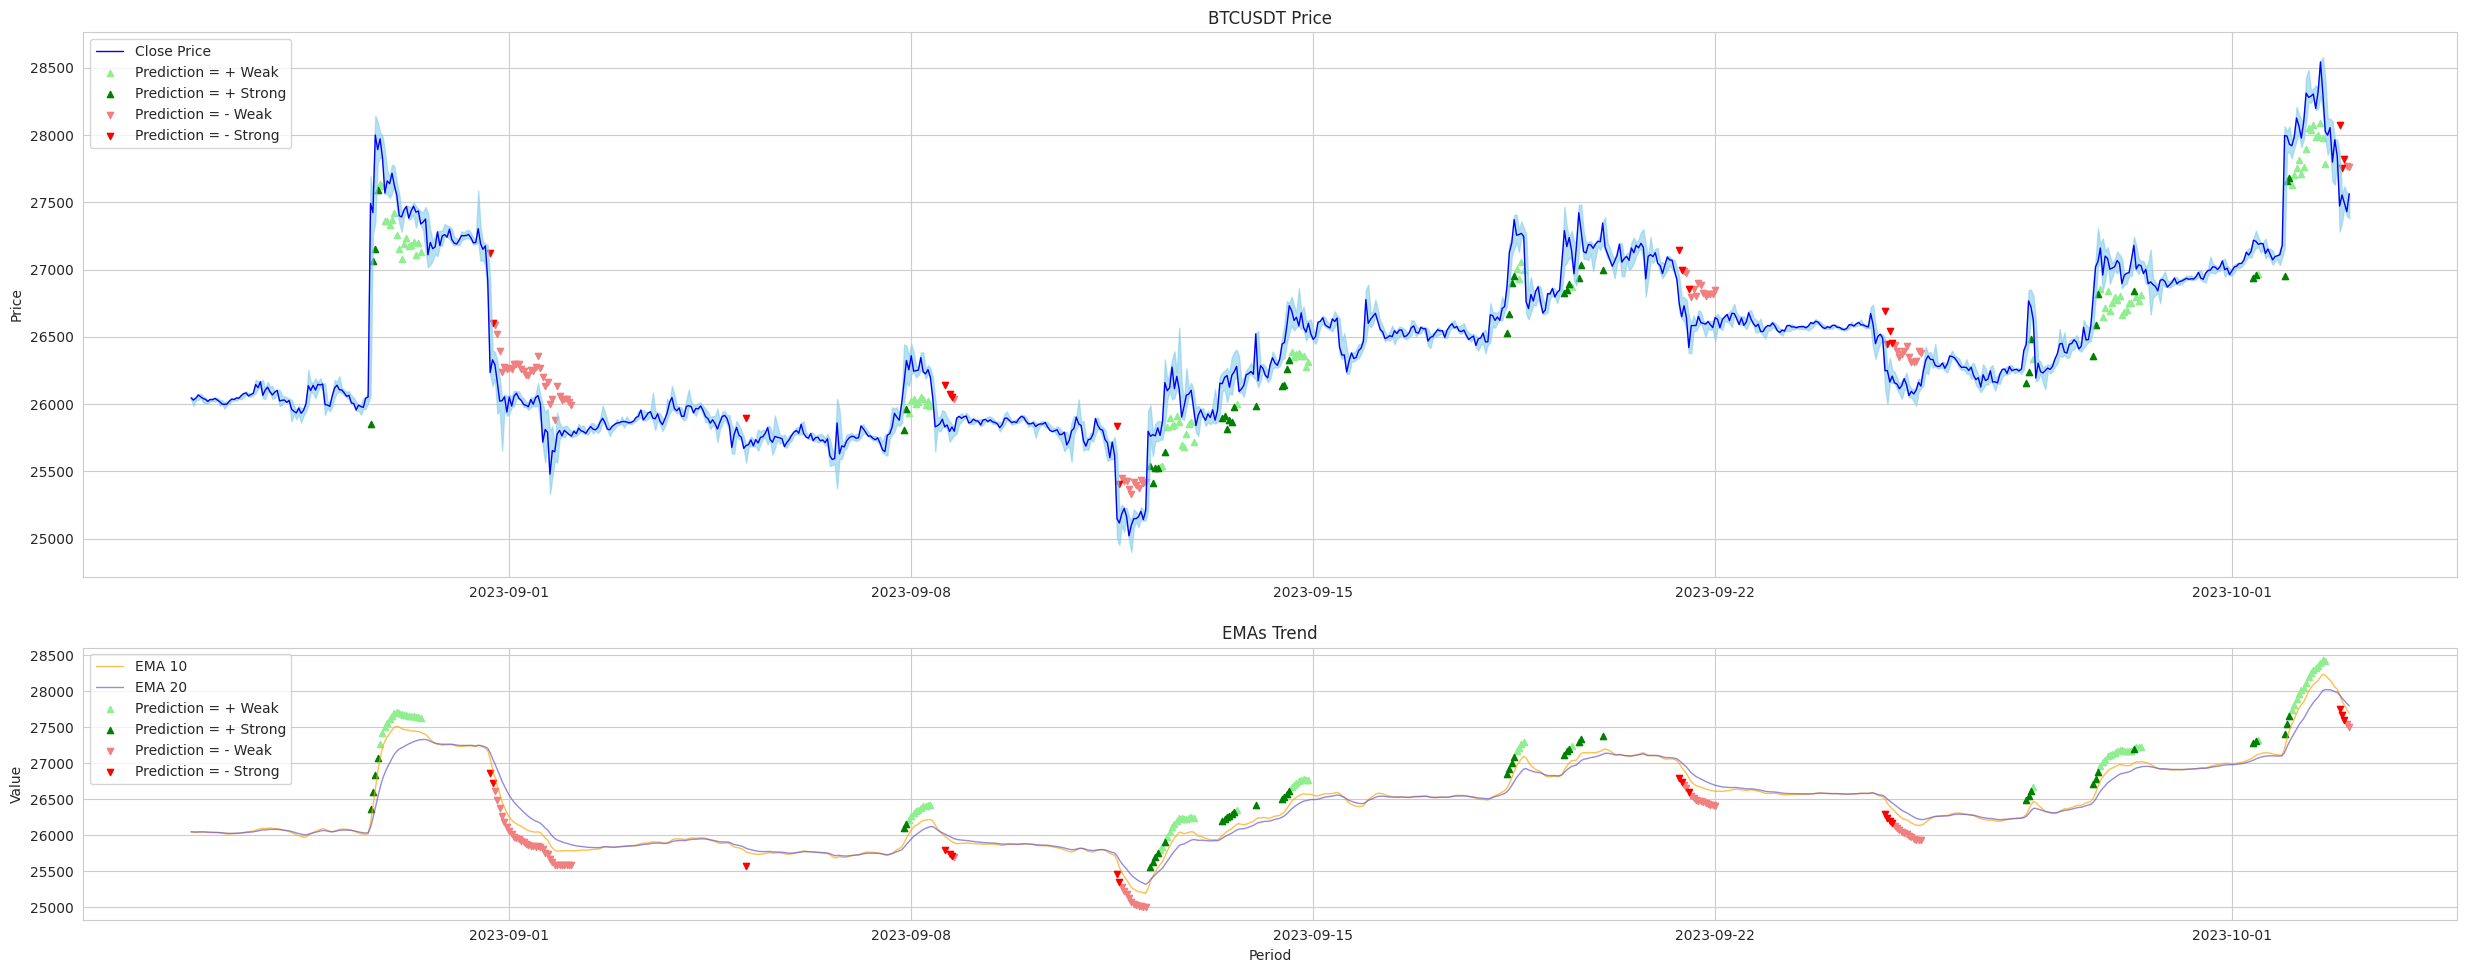

In [202]:
import talib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_live_trend_prediction(df_live, T, model_name = 'tmp_model', model_path = './models/'):

    # Get prediction result
    y_live_pred = predict_live_data(df_live, T, model_name = model_name, model_path = model_path)
    
    pred_result = df_live.copy()
    pred_result.loc[:, 'prediction'] = y_live_pred

    # ohlc
    pred_result['ohlc'] = (pred_result['open'] + pred_result['high'] + pred_result['low'] + pred_result['close']) / 4

    # diff between ema 10 and 20
    pred_result['ema_10'] = talib.EMA(pred_result['ohlc'], timeperiod=10)
    pred_result['ema_20'] = talib.EMA(pred_result['ohlc'], timeperiod=20)

    pred_result.dropna(inplace=True)

    # Plot
    # Set seaborn style
    sns.set_style("whitegrid")

    # Create subplots: one for price, one for MACD histogram
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,10), gridspec_kw={'height_ratios': [2, 1]})
    fig.tight_layout(pad=3.0)

    # Plotting price data on the first subplot
    axes[0].plot(pred_result['close'], label='Close Price', color='blue', linewidth=1)

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['low'] - 200, 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['low'] - 200, 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['high'] + 200, 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[0].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['high'] + 200, 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[0].set_title('BTCUSDT Price')
    axes[0].set_ylabel('Price')
    axes[0].legend(loc='upper left')

    # Filling in the area between high and low prices (optional)
    axes[0].fill_between(pred_result.index, pred_result['high'], pred_result['low'], color='skyblue', alpha=0.6)

    # line plot EMA 10 and 20
    axes[1].plot(pred_result.index, pred_result['ema_10'], label='EMA 10', color='orange', alpha=0.7, linewidth=1)
    axes[1].plot(pred_result.index, pred_result['ema_20'], label='EMA 20', color='slateblue', alpha=0.7, linewidth=1)

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 1].index, 
            pred_result[pred_result['prediction'] == 1]['ema_10'] + 200, 
            color='lightgreen', 
            marker='^', 
            label='Prediction = + Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == 2].index, 
            pred_result[pred_result['prediction'] == 2]['ema_10'] + 200, 
            color='green', 
            marker='^', 
            label='Prediction = + Strong',
            s=20
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -1].index, 
            pred_result[pred_result['prediction'] == -1]['ema_10'] - 200, 
            color='lightcoral',
            marker='v', 
            label='Prediction = - Weak',
            s=20,
        )

    axes[1].scatter(
            pred_result[pred_result['prediction'] == -2].index, 
            pred_result[pred_result['prediction'] == -2]['ema_10'] - 200, 
            color='red',
            marker='v', 
            label='Prediction = - Strong',
            s=20,
        )

    axes[1].set_title('EMAs Trend')
    axes[1].set_ylabel('Value')
    axes[1].set_xlabel('Period')
    axes[1].legend(loc='upper left')

    # Display the plot
    plt.show()

    return None

plot_live_trend_prediction(df_live, T, model_name = 'dl_btc_ema_3hr_trend_unseen')

### Summary of Prediction for the Next 3 Hours Trend on Live BTCUSDT price:

**Model Performance Metrics**:
- **Accuracy**: 87.56%
- **Weighted F1-Score**: 86.44%

**Class-by-Class Performance**:
- **No Clear Trend (0.0)**:
  - The model was most proficient at detecting a neutral trend with a **precision of 0.92** and a **recall of 0.97**.
  
- **Strong Downward Trend (-2.0)**:
  - The performance for this class was modest with a **precision of 0.76**, but a relatively low **recall of 0.33**, indicating the model struggles with identifying strong downward trends when they actually occur.

- **Weak Downward Trend (-1.0)**:
  - The model had a good **precision of 0.71** and an impressive **recall of 0.91**. This indicates that the model is better at detecting the early or weak downward trends than strong ones.

- **Strong Upward Trend (2.0)**:
  - The model achieved a **precision of 0.70**, but a relatively lower **recall of 0.43**, suggesting that it might not always catch strong upward trends when they occur.

- **Weak Upward Trend (1.0)**:
  - This class saw a **precision of 0.73** and a **recall of 0.76**, indicating a balanced performance.

**Insights and Observations**:
- The model excels at identifying periods with no clear trend. This is evident from the high precision and recall values for the "0.0" class.
- The model shows some struggle in predicting strong trend shifts, both upward and downward, as seen from the recalls for "-2.0" and "2.0".
- In the context of the trend movement patterns, the model might often skip the strong trend state and predict the weak trend or neutral state directly. 
    - This could be indicative of its `challenge in capturing the strong beginning of trends`, 
    - But it seems more `confident` in predicting `how long the trend might last`.

----
----
----